<a href="https://colab.research.google.com/github/danfolador/recpadroes/blob/main/RecPad_Exercicio05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCÍCIO 05**

Aluno: Daniel Folador Rossi

Matrícula: 20201mpca0306

---
1. Crie a sua heurística para escolher a melhor característica para um nó
    de uma árvore de decisão e compare com a implementação feita nos vídeos
    postados nesse tópico aqui no AVA e com a implementação do scikit learn.
2. Faça comparações plotando as regiões de decisão com resubstituição para
    a base iris e as características usadas nos vídeos.
3. Também faça comparações usando validação cruzada com pelo menos 3 bases
    de classificação com atributos contínuos.
4. Escreva um parágrafo expondo sua interpretação dos resultados obtidos.


In [ ]:
#======================================================
# INICIALIZAÇÃO
#======================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from collections import Counter
from sklearn.datasets import load_iris
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#======================================================
# BANCOS DE DADOS
#======================================================

#------------------------------------------------------
# Base Iris
#------------------------------------------------------
bd = load_iris()
X, y = bd.data[:,2:], bd.target

feature_names = bd.feature_names
target_names = bd.target_names

N_classes = len(set(y))
classes = set(y)

print("=========================================================")
print(" IRIS DATASET")
print("=========================================================")
print(bd.keys())
print("X.shape=",X.shape)
print("y.shape=",y.shape)
print("No de classes=",N_classes)
print("classes=",classes)
print("")

#------------------------------------------------------
# Funcao para abrir outras bases
#------------------------------------------------------

def Abrir_bd(url, nome, tipo):
    
    if tipo=='xls':
        bd = pd.read_excel(url)
        
    if tipo=='csv':
        bd = pd.read_csv(url) 
        

    X  = bd.iloc[:, 0:-1]
    y = bd.iloc[:, -1]
    features = list(bd.columns)
    
    X = pd.DataFrame.to_numpy(X)
    y = pd.DataFrame.to_numpy(y)    
    
    N_classes = len(set(y))
    classes = set(y)

    print("=========================================================")
    print(nome)
    print("=========================================================")
    print("features =",features)
    print("X.shape=",X.shape)
    print("y.shape=",y.shape)
    print("No de classes=",N_classes)
    print("classes=",classes)
    print("")

    return X, y

 IRIS DATASET
dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
X.shape= (150, 2)
y.shape= (150,)
No de classes= 3
classes= {0, 1, 2}



In [ ]:
#======================================================
# FUNCOES DE APOIO
#======================================================

def maisFreq(y):
    return Counter(y.flat).most_common(1)[0][0]

def ImpurezaGini(y):
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def ImpurezaValor(x, y, valor_ref):
    maiores = x>valor_ref
    impurezaMaiores = ImpurezaGini(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = ImpurezaGini(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

def MelhorValor(x,y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = ImpurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza= impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

def MelhorValor2(x,y):
    
    valores, impurezas = [], []
    probab_lim = 0.90 
    iteracoes = 100
    result = None
    menorImpureza = float('inf')
    x_subset = np.array(x)
    y_subset = np.array(y)
    
    for i in range(1,iteracoes):
        
        probab = max(1-(i/(probab_lim*iteracoes)), 0)
                 # Probab de se escolher um valor aleatório ao invés da média
                 # Começa com Prob=90% na iteração=0
                 # caindo linearmente para Prob=0% na iteração=45 (0,9 do total de iteracoes)

        while True:
            valor = np.mean(x_subset)
            num_aleat = np.random.uniform(0,1,size=1)
            if (num_aleat <= probab): valor = random.sample(set(x_subset), 1)
          
            impTotal, impMaiores, impMenores = ImpurezaValor(x, y, valor)
            
            valores.append(valor)
            impurezas.append(impTotal)   
            maiores = x_subset>valor
     
            if impTotal < menorImpureza:
                menorImpureza = impTotal
                if impMaiores == 0 or impMenores == 0:
                    break
                if impMaiores < impMenores:
                    x_subset = x_subset[maiores]
                    y_subset = y_subset[maiores]
                else:
                    x_subset = x_subset[~maiores]
                    y_subset = y_subset[~maiores]
            else:
                break
        
    result = valores[np.argmin(impurezas)]
    
    return result, menorImpureza


def MelhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = MelhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

def MelhorCaracteristica2(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = MelhorValor2(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

def plotDecisao(X, y, implementacao, modelo, feature_names, target_names):
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2,100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2,100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]   
    ypred = modelo.predict(Xdec)
    plt.figure(figsize=(8,4))
    plt.title(implementacao)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.2)
    for k in set(y):
        #Plot da caracteristica 0 vs 1
        plt.plot(X[:, 0][y==k],X[:, 1][y==k], 'o', label=f"{target_names[k]}= [{k}]")
    plt.xlabel(f"X[0]: {feature_names[0]}")
    plt.ylabel(f"X[1]: {feature_names[1]}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show


In [ ]:
#======================================================
# ARVORES DE DECISAO
#======================================================
#------------------------------------------------------
# Algoritmo1 - Arvore implementada no video
#------------------------------------------------------

class Arvore1(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = MelhorCaracteristica(X, y)        
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore1()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore1()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFreq(y)            
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

#------------------------------------------------------
# Algoritmo2 - Arvore nova
#------------------------------------------------------

class Arvore2(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = MelhorCaracteristica2(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore2()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore2()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFreq(y)            
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y


#------------------------------------------------------
# Algoritmo3 - Arvore do SKLEARN
#------------------------------------------------------

Arvore3 = DecisionTreeClassifier()


 SCORES
---------------------------------------------------------
Implementacao1: Aula                0.9533333333333334
Implementacao2: Nova Heuristica     0.9400000000000001
Implementacao3: Sklearn             0.9533333333333334



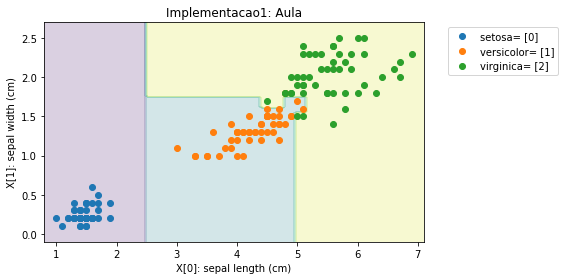

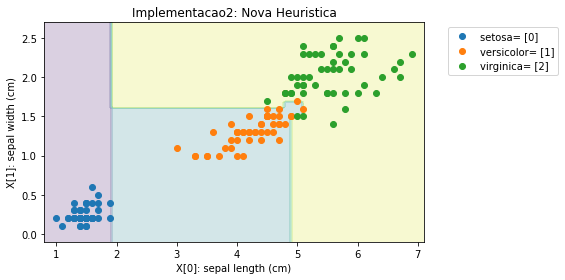

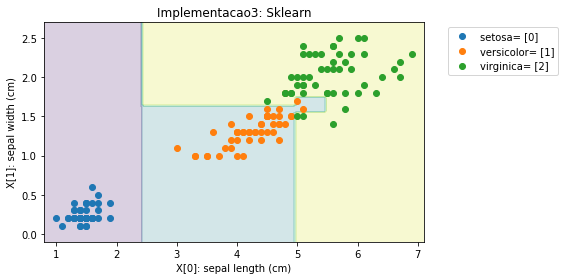

In [ ]:
#======================================================
# COMPARACAO VISUAL
#======================================================

modelos = [Arvore1(),
           Arvore2(),
           Arvore3]

implements = ['Implementacao1: Aula',
              'Implementacao2: Nova Heuristica',
              'Implementacao3: Sklearn']


formatacao="{:<35} {:<10}"

print(' SCORES')
print('---------------------------------------------------------')

for impl, modelo in zip(implements, modelos):
    modelo.fit(X,y)
    plotDecisao(X, y, impl, modelo, feature_names, target_names)
    scores = cross_validate(modelo, X, y)
    print(formatacao.format(impl ,np.mean(scores['test_score'])))

print('')


In [ ]:
#======================================================
# VALIDACAO
#======================================================
# FONTE1: https://archive.ics.uci.edu/ml/datasets/Cervical+Cancer+Behavior+Risk
# FONTE2: https://archive.ics.uci.edu/ml/datasets/Immunotherapy+Dataset
# FONTE3: https://archive.ics.uci.edu/ml/datasets/Cryotherapy+Dataset+


nomes = [' CERVICAL CANCER BEHAVIOR RISK DATASET',
         ' IMMUNOTHERAPY DATASET',
         ' CRYOTHERAPY DATASET',]

tipos= ['csv',
        'xls',
        'xls']

urls = ['https://archive.ics.uci.edu/ml/machine-learning-databases/00537/sobar-72.csv',
        'https://archive.ics.uci.edu/ml/machine-learning-databases/00428/Immunotherapy.xlsx',
        'https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx']

for url, nome, tipo in zip(urls, nomes, tipos):
    X, y = Abrir_bd(url, nome, tipo)


    print(' SCORES')
    print('---------------------------------------------------------')    

    for impl, modelo in zip(implements, modelos):
        modelo.fit(X,y)
        scores = cross_validate(modelo, X, y)
        print(formatacao.format(impl ,np.mean(scores['test_score'])))
        
    print('')

 CERVICAL CANCER BEHAVIOR RISK DATASET
features = ['behavior_sexualRisk', 'behavior_eating', 'behavior_personalHygine', 'intention_aggregation', 'intention_commitment', 'attitude_consistency', 'attitude_spontaneity', 'norm_significantPerson', 'norm_fulfillment', 'perception_vulnerability', 'perception_severity', 'motivation_strength', 'motivation_willingness', 'socialSupport_emotionality', 'socialSupport_appreciation', 'socialSupport_instrumental', 'empowerment_knowledge', 'empowerment_abilities', 'empowerment_desires', 'ca_cervix']
X.shape= (72, 19)
y.shape= (72,)
No de classes= 2
classes= {0, 1}

 SCORES
---------------------------------------------------------
Implementacao1: Aula                0.821904761904762
Implementacao2: Nova Heuristica     0.8361904761904763
Implementacao3: Sklearn             0.7923809523809523

 IMMUNOTHERAPY DATASET
features = ['sex', 'age', 'Time', 'Number_of_Warts', 'Type', 'Area', 'induration_diameter', 'Result_of_Treatment']
X.shape= (90, 7)
y.shape=

**DISCUSSÃO**

A nova heurística implementada buscou mesclar a heutística apresentada em aula com o algoritmo de **Simulated Annealing**: 

1. Separa os dados em dois subconjuntos pela média dos valores (numpy.mean), ao invés da média entre o valor mínimo e máximo
2. Escolhe o subconjunto que possui a menor impureza Gini
3. Repete a divisão até encontrar o valor que retorna a menor impureza
4. Com este valor, calcula a melhor característica
5. Os passos 1-4 são repetidos em 100 iterações. A cada iteração, existe a probabilidade dos subconjuntos serem dividos não pela média, mas por um valor aleatório dentro do subconjunto de dados. Essa probabilidade começa em 90% na iteração=0, caindo linearmente para 0% na iteração=90, e se mantendo 0% a partir de então.

Foram feitas algumas rodadas para verificar o desempenho dessa implementação. Para a base Iris, as regiões de decisão ficaram bastante parecidas. Para as demais bases, a validação cruzada mostrou que a nova implementação pode alcançar ajustes melhores que a implementação da aula e do sklearn, mas devido ao fator aleatório, em alguns resultados esta implementação fica aquém das demais. Um número maior de iterações se mostrou muito lento para pouca melhora. O ideal seria melhorar a aleatoriedade, usando um "chute" mais consciente do que apenas um valor aleatório do subconjunto.

O Simulated Annealing é um bom algoritmo para fugir de mínimos locais, mas muitas vezes pode exigir muito computacionalmente.